In [1]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.extensions import HamiltonianGate
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
from qiskit.quantum_info import Statevector, Operator
from qiskit.opflow import CircuitStateFn
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
import scipy 
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
## import optimisers
from qiskit.algorithms.optimizers import COBYLA
from scipy.optimize import minimize

In [3]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')


In [4]:
## sub-routines for Grover Search ~
def to_oracle(pattern, name= 'oracle'):
    """ Convert a given pattern to an oracle
        input: pattern= a numpy vector with binarry entries 
        output: oracle.Gate    """

    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]=='0'): qc.x(qr[q])
    qc.x(a)
    qc.h(a)
    qc.mcx(qr, a)
    qc.h(a)
    qc.x(a)
    for q in range(l):
        if(pattern[q]=='0'): qc.x(qr[q])
    #qc.barrier()
    return qc.to_gate()

def diffuser(l):
    """ Gnerate the Diffuser operator for the case where the initial state  is 
        the equal superposition state of all basis vectors 
        input: l= no. of qubits
        output: diffuser.Gate    """
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    circuit = QuantumCircuit(qr, a, name= 'Diff.')
    
    circuit.h(qr)
    circuit.x(qr)
    
    circuit.x(a)
    circuit.h(a)
    circuit.mcx(qr ,a)
    circuit.h(a)
    circuit.x(a)

    circuit.x(qr)
    circuit.h(qr)
          
    return circuit.to_gate()

def grover_iterate(qc, oracles, diffuser, qreg_u, ancilla, steps):
    """ Run full Grover iteration for given number of steps.
        input:
        qc: QuantumCiruit to append to 
        oracles: a list of oracles generated from 'to_oracle()' function 
        diffuser: a diffuser from 'diffuser()' function 
        steps: no. of grover iterates"""
    for step in range(steps):
        for oracle in oracles:
            qc.append(oracle, list(range(qc.num_qubits)) )
        qc.append(diffuser, list([q for q in qreg_u])+ list(ancilla) )
        # qc.barrier()
    return qc

def run(patterns, grover_steps ):
    
    dim = len(patterns[0])
    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
    # create diffuser ~\
    diff = diffuser(dim)
    # create circuit ~\
    
    qreg = QuantumRegister(dim, name= 'init')
    ancilla = AncillaRegister(1, name='ancilla')
    creg = ClassicalRegister(dim)
    qc = QuantumCircuit(qreg, creg, ancilla)
    qc.h(qreg)
    # run grover update steps ~\
    grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
    qc.measure(qreg, creg)
    
    job = execute(qc, backend= aer, shots= 1024)
    plot_histogram(job.result().get_counts())
    
    return qc, job



## Variational Grover Search 
Here my aim is to train a variational circuit to reproduce the action of a Grover operator following the research article in https://arxiv.org/pdf/1805.09337.pdf


The operation here proceeds by generating a variational equivalent of the operators used in generalised grover search algorithm.

Say $\{\ket{\phi}\}$ is the set of 'good' states and $\ket{\psi_0}$ is the intial state that we begin with, then we define the corrsponding projectors as $P_{\phi}$ as the projector on the 'good' states and $P_{\psi_0}$ as the projector on the initial state.

The algorithm proceeds by repeatedly applying the follwoing unitary operators $\ket{\psi_0}$ 
$$  U_i(\alpha) = e^{i\alpha P_{\psi_0}}    $$
$$  U_p(\beta) = e^{i\beta P_{\phi} }       $$
in succesion on the initial state $\ket{\psi_0}$ to obtain the variational 'ansatz' state 
$$\ket{\psi_{(\vec{\alpha}, \vec{\beta})}} = U_i(\alpha_p)U_p(\beta_p)  . .U_i(\aplha_2)U_p(\beta_2)U_i(\aplha_1)U_p(\beta_1) \ket{\psi_0} $$


Once the variational state $\ket{\psi_{\vec{\alpha}, \vec{\beta}}}$ is obtained, we variationally update the parameters $\vec{\alpha} = {\alpha_1, \alpha_2,. . \alpha_p}$ and $\vec{beta} = {\beta_1, \beta_2, . . \beta_p}$, by minimizing the projection of the ansatz state on the orthogonal component of $P_{\phi}$ i.e 

$$  \vec{\alpha}, \vec{\beta} = min_{\alpha, \beta} \bra{\psi_{\vec{\alpha}, \vec{\beta}}} \mathbb{I} - P_{\phi} \ket{\psi_{\vec{\alpha}, \vec{\beta}}}$$

In [5]:
# # projector_init =  Statevector.from_label('+'*(stvc.num_qubits  )).to_operator()
# # # is_hermitian_matrix(projector_init)
# # projector_init.conjugate() == projector_init
# # HamiltonianGate(projector_init, -1)
# patterns = [ '000', '111']
# projector_init, projector_good = var_grover_projectors(patterns, init= 'all+')
# # unitary_good = [ HamiltonianGate(projector_good, -1*alpha, label='U_good: '+ str(alpha)) for alpha in alphas ]
# # unitary_init = [ HamiltonianGate(projector_init, -1*beta, label= 'U_init: '+ str(beta)) for beta in betas]

In [6]:
def var_grover_projectors(patterns, init = 'all+', init_state_prep = None):
    """ Returns projectors on the good states and the initial state
         Args: 
            patterns= list of states in string form . Eg. ['000', '101']
            init= iniial state
         Returns: projectors on initial states and good states"""

    states_good = []
    projector_init = 0
    for pattern in patterns:
        stvc = Statevector.from_label(pattern)
        states_good.append(stvc)
    projector_good = states_good[0].to_operator()
    for i in range(1,len(states_good)):  projector_good = projector_good + states_good[i].to_operator()
    if init== 'all+': 
        projector_init =  Statevector.from_label('+'*(stvc.num_qubits  )).to_operator()
    else:
        projector_init = Statevector.from_instruction(init_state_prep).to_operator()
        
    return projector_init, projector_good


In [7]:
def var_grover_circuit(patterns, params,  init= 'all+', init_state_prep = None, method= 'stv', shots= 1024):
    """ Returns variational grover circuit 
        Args:
            patterns= list of states in string form . Eg. ['000', '101']
            init= iniial state
            init_state_prep = circuit to prepare the initial state
    """
    p = len(params)//2
    alphas = params[:p]
    betas = params[p:]
    
    if len(alphas) != len(betas):
        raise ValueError("alpha beta has incompatible length")

    nq = len(patterns[0])
    qreg = QuantumRegister(nq , name= 'qreg')
    # creg = ClassicalRegister(nq , name= 'creg')
    # qc = QuantumCircuit(qreg, creg)
    qc =QuantumCircuit(qreg)
    
    if init== 'all+': qc.h(qreg)
    else: qc.compose(init_state_prep)
    
    projector_init, projector_good = var_grover_projectors(patterns, init= init, init_state_prep= init_state_prep)
    unitary_good = [ HamiltonianGate(projector_good, -1*alpha, label='U_good: '+ str(alpha)) for alpha in alphas ]
    unitary_init = [ HamiltonianGate(projector_init, -1*beta, label= 'U_init: '+ str(beta)) for beta in betas]

    for p in range(len(alphas)):
        qc = qc.compose(unitary_good[p])
        qc = qc.compose(unitary_init[p])

    return qc


In [8]:
def var_grover_get_expectation( params, patterns ,method= 'stv', shots= 1024):
    """ Returns the expectation value of the orthogonal component of the projector on good states for a give ansatz state
        Args:
            params= Values of variational parameters
            patterns= list of states in string form . Eg. ['000', '101']
            method= Method of obtaining the expectation (statevector simulation/ shot-based measurement)
            """
    p = len(params)//2
    alphas = params[:p]
    betas = params[p:]
    
   
    if len(alphas) != len(betas):
        raise ValueError("alpha beta has incompatible length")
    
    projector_init, projector_good = var_grover_projectors(patterns)
    qc = var_grover_circuit(patterns, params)
    nq = qc.num_qubits

    if method == 'stv' :
        job = execute(qc, backend= stv, shots= shots)
        state = job.result().get_statevector()
        # state = CircuitStateFn(qc)
        op = Operator(np.identity(2**nq)) - projector_good
        exp_op = state.expectation_value(op)
    ## todo: add genralisation for method= 'counts' for counts based calculation of 'exp_op'
    # if method == 'counts' :
    #     job.execute(qc, backend= qsm, shots= shots)

    
    return exp_op


In [30]:
global patterns
patterns = [ '0010', '1100','1110','0101' ]
# alphas, betas = [pi], [pi]
# params = alphas + betas

steps = 5 
params = np.random.rand(2*steps)

In [24]:
## trial ~ variational grover operator
qc = var_grover_circuit(patterns, params )
# qc.draw()

In [20]:
## optimization subroutine : scipy
# steps = 5
result = minimize( var_grover_get_expectation, np.random.rand(2*steps) , (patterns ) , method= 'COBYLA' )

In [31]:
## trial ~ variational grover operator
qc = var_grover_circuit(patterns, result.x )
# qc.draw()

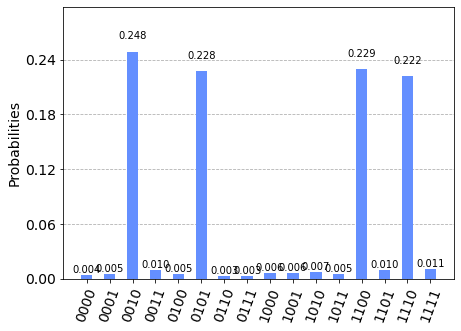

In [32]:
qc.measure_all()
counts = execute(qc, backend= qsm, shots= 1024).result().get_counts()
plot_histogram(counts)
# counts

In [14]:
# patterns = [ '000', '111']
# # states_good = []
# # for pattern in patterns:
# #     stvc = Statevector.from_label(pattern)
# #     states_good.append(stvc)
# # projector_good = states_good[0].to_operator()
# # for i in range(1,len(states_good)):  projector_good = projector_good + states_good[i].to_operator()
# # alpha, beta = 1, 1
# # unitary_good = HamiltonianGate(projector_good, -1*alpha, label='U_good')
# # unitary_init = HamiltonianGate(projector_init, -1*beta, label= 'U_init')

# alphas, betas = [pi], [pi]
# params = alphas + betas
# # nq = len(patterns[0])
# # qreg = QuantumRegister(len(patterns[0]), name= 'qreg')
# # creg = ClassicalRegister(len(patterns[0]), name= 'creg')
# # qc = QuantumCircuit(qreg, creg)
# # qc.h(qreg)

# # # if init== 'all+': qc.h(qreg)
# # ## todo: add generalizability to prepare init state arbitraliy

# # projector_init, projector_good = var_grover_projectors(patterns)
# # unitary_good = [ HamiltonianGate(projector_good, -1*alpha, label='U_good: '+ str(alpha)) for alpha in alphas ]
# # unitary_init = [ HamiltonianGate(projector_init, -1*beta, label= 'U_init: '+ str(beta)) for beta in betas]

# # for p in range(len(alphas)):
# #     qc = qc.compose(unitary_good[p])
# #     qc = qc.compose(unitary_init[p])
# var_grover_get_expectation(params, patterns)


# # qc.draw()


### Remarks
1. For using single iterate of variational unitary evolution operators the paramters settle on $\pi$ as required.
2. One significant advantgage of the variational method is, that for a fixed number of 'steps' we only need to train the model once with any arbitrary choice of 'good' states. The variational operators retain their efficeincy in retrieval of states, independent of the 'good' states choosen or even the dimensionality of the 'good' states.

### scratch space

In [15]:
q = QUa

NameError: name 'QUa' is not defined

In [ ]:
unitary_good = HamiltonianGate(projector_good, -1*alpha, label='U_good')
unitary_init = HamiltonianGate(projector_init, -1*beta, label= 'U_init')

NameError: name 'projector_good' is not defined

In [ ]:
p = -1*np.identity(4) + np.sin(pi/4)*np.identity(4) 
ui = HamiltonianGate(p, 1, label= '1')


In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.append(ui, [0,1])

qc.draw()

┌───┐┌────┐
q_0: ┤ H ├┤0   ├
     └───┘│  1 │
q_1: ─────┤1   ├
          └────┘

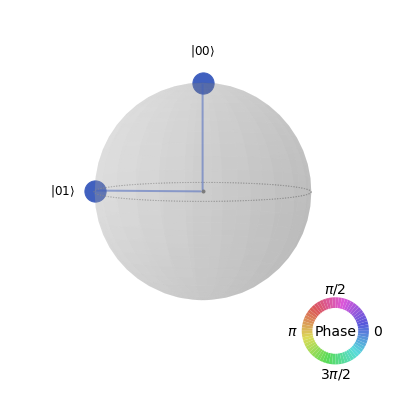

In [ ]:
plot_state_qsphere(qc)